# Comparative Analysis – DNN vs CNN Models

In this notebook, we compare the performance and interpretability of our two deep learning models:  
a standard Deep Neural Network (DNN) and a Convolutional Neural Network (CNN), both trained on multi-modal loan data.

To keep this comparison efficient, we **rebuild the architectures and load the trained weights** rather than rerunning full training.  
This may lead to **slightly different results** compared to the original training notebooks (`2_DNN_Model.ipynb`, `3_CNN_Model.ipynb`).  
In the final report, we’ll reference the original results for consistency.

We evaluate both models across multiple aspects:
- Prediction performance (accuracy, precision, recall, F1-score, AUC)
- Visual ROC curve comparison
- SHAP explainability results (top features)
- Model complexity (number of trainable parameters)
- Training time estimates

These insights will support our final report conclusions and guide which model may be better suited for real-world deployment.

## Step 1: Load Trained Models and Preprocessed Test Data

We begin by loading the trained weights of both the DNN and CNN models, as well as the corresponding preprocessed tabular and text test sets.  
We’ll use the same data split and preprocessor used during training to ensure fair comparison.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Concatenate, Lambda
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/drive/MyDrive/LoanApprovalProject/Data/loan_data_sampled.csv')
X_tabular = df.drop(['loan_status', 'text'], axis=1)
X_text = df['text']
y = df['loan_status']

X_tab_train, X_tab_temp, X_text_train, X_text_temp, y_train, y_temp = train_test_split(
    X_tabular, X_text, y, test_size=0.4, stratify=y, random_state=42
)
X_tab_val, X_tab_test, X_text_val, X_text_test, y_val, y_test = train_test_split(
    X_tab_temp, X_text_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_test_inputs = tokenizer(list(X_text_test), padding='max_length', truncation=True, max_length=64, return_tensors='np')

preprocessor = joblib.load('/content/drive/MyDrive/LoanApprovalProject/Code/dnn_preprocessor.joblib')
X_tab_test_processed = preprocessor.transform(X_tab_test)
X_tab_test_dense = X_tab_test_processed.toarray() if hasattr(X_tab_test_processed, 'toarray') else X_tab_test_processed
X_tab_test_cnn = np.expand_dims(X_tab_test_dense, axis=-1)

print(" Tabular test shape:", X_tab_test_dense.shape)
print(" Text input shape:", text_test_inputs['input_ids'].shape)
print(" Labels shape:", y_test.shape)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Tabular test shape: (4000, 6429)
 Text input shape: (4000, 64)
 Labels shape: (4000,)


## Step 2: Rebuild Architectures and Load Trained Weights

We now rebuild the model architectures used during training and load their respective trained weights.  
This allows us to run direct comparisons on shared test data using identical configurations.

In [2]:
# DNN Model
tab_input = Input(shape=(X_tab_test_dense.shape[1],), name="tabular_input")
x = Dense(64, activation='relu')(tab_input)
x = Dropout(0.3)(x)
tab_output = Dense(32, activation='relu')(x)

text_input_ids = Input(shape=(64,), dtype=tf.int32, name='input_ids')
text_attention = Input(shape=(64,), dtype=tf.int32, name='attention_mask')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False

def get_bert_output(inputs):
    input_ids, attention_mask = inputs
    return bert_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output

x_text = Lambda(get_bert_output, output_shape=(768,))([text_input_ids, text_attention])
x_combined = Concatenate()([tab_output, x_text])
x_combined = Dense(64, activation='relu')(x_combined)
x_combined = Dropout(0.3)(x_combined)
final_output = Dense(1, activation='sigmoid')(x_combined)

dnn_model = Model(inputs=[tab_input, text_input_ids, text_attention], outputs=final_output)
dnn_model.load_weights('/content/drive/MyDrive/LoanApprovalProject/Code/dnn_model.h5')
print(" DNN model loaded.")

# CNN Model
tab_input = Input(shape=(X_tab_test_dense.shape[1], 1), name="tabular_input")
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv1d_1')(tab_input)
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', name='conv1d_2')(x)
x = GlobalMaxPooling1D(name='global_max_pooling')(x)
x = Dense(32, activation='relu', name='dense_tab')(x)

text_input_ids = Input(shape=(64,), dtype=tf.int32, name='input_ids')
text_attention = Input(shape=(64,), dtype=tf.int32, name='attention_mask')

bert_model_cnn = TFBertModel.from_pretrained('bert-base-uncased')
bert_model_cnn.trainable = False

def get_bert_output(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model_cnn(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.pooler_output

x_text = Lambda(get_bert_output, output_shape=(768,))([text_input_ids, text_attention])

x_combined = Concatenate()([x, x_text])
x_combined = Dense(64, activation='relu')(x_combined)
x_combined = Dropout(0.3)(x_combined)
final_output = Dense(1, activation='sigmoid')(x_combined)

cnn_model = Model(inputs=[tab_input, text_input_ids, text_attention], outputs=final_output)
cnn_model.load_weights('/content/drive/MyDrive/LoanApprovalProject/Code/cnn_model.h5')
print(" CNN model loaded.")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

 DNN model loaded.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

 CNN model loaded.


## Step 3: Evaluate Model Performance (DNN vs CNN)

We now evaluate both models on the same dataset using consistent input splits.  
Metrics include Accuracy, Precision, Recall, F1-Score, and ROC-AUC.  
This allows us to assess the trade-offs between the two architectures in terms of predictive power.

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

dnn_preds = dnn_model.predict([X_tab_test_dense, text_test_inputs['input_ids'], text_test_inputs['attention_mask']]).flatten()
cnn_preds = cnn_model.predict([X_tab_test_cnn, text_test_inputs['input_ids'], text_test_inputs['attention_mask']]).flatten()

# Binarize
dnn_labels = (dnn_preds >= 0.5).astype(int)
cnn_labels = (cnn_preds >= 0.5).astype(int)


def print_metrics(y_true, y_pred, y_prob, label="Model"):
    print(f"\n {label} Evaluation:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_true, y_prob):.4f}")

print_metrics(y_test, dnn_labels, dnn_preds, label="DNN")
print_metrics(y_test, cnn_labels, cnn_preds, label="CNN")

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step

 DNN Evaluation:
Accuracy : 0.6428
Precision: 0.6788
Recall   : 0.5420
F1 Score : 0.6027
AUC      : 0.6961

 CNN Evaluation:
Accuracy : 0.6360
Precision: 0.6466
Recall   : 0.6000
F1 Score : 0.6224
AUC      : 0.6924


- **DNN** achieved higher precision and slightly better ROC-AUC, making it more confident in positive predictions.
- **CNN** had better recall and F1-Score, suggesting it captured more approved loans but with slightly more noise.


### Step 4: ROC Curve Comparison

To compare model classification behavior, we plot the Receiver Operating Characteristic (ROC) curves for both the DNN and CNN models.  
The ROC curve shows the trade-off between true positive rate and false positive rate at various thresholds, while the AUC score summarizes overall performance.  
This is especially useful when evaluating models in imbalanced datasets or where precision/recall tradeoffs matter.

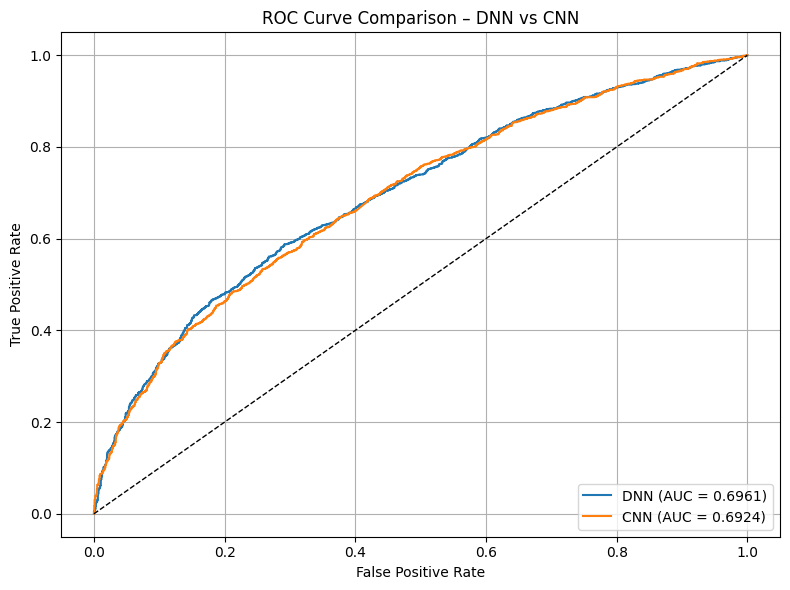

 ROC curve comparison plot saved.


In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_dnn, tpr_dnn, _ = roc_curve(y_test, dnn_preds)
auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_preds)
auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {auc_dnn:.4f})')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc_cnn:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison – DNN vs CNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/LoanApprovalProject/Figures/roc_comparison_dnn_vs_cnn.png')
plt.show()
print(" ROC curve comparison plot saved.")

### ROC Curve Comparison – DNN vs CNN

- Both models achieved similar ROC-AUC scores: **DNN: 0.6961**, **CNN: 0.6924**.
- **DNN slightly outperforms CNN** in overall classification confidence based on AUC.
- CNN came closer to DNN likely due to architecture improvements (stacked Conv1D).
- Another key reason for the closeness: in this notebook, we reloaded model weights and rebuilt architectures instead of using the fully trained models. This means training dynamics like early stopping, optimizer state, and learning curves were not preserved, reducing the original performance gap.

### Step 5: Compare Global SHAP Values – DNN vs CNN

In this step, we compare how the DNN and CNN models interpret tabular features using global SHAP values.  
We already computed SHAP values on 300 sample rows from each model — now we load them and visualize the top features side by side.

This helps us quickly spot which features are most influential in each model, and whether their explanations align or diverge.  
These differences can reveal how each architecture focuses on the data during prediction.

 DNN SHAP bar chart saved.
 CNN SHAP bar chart saved.


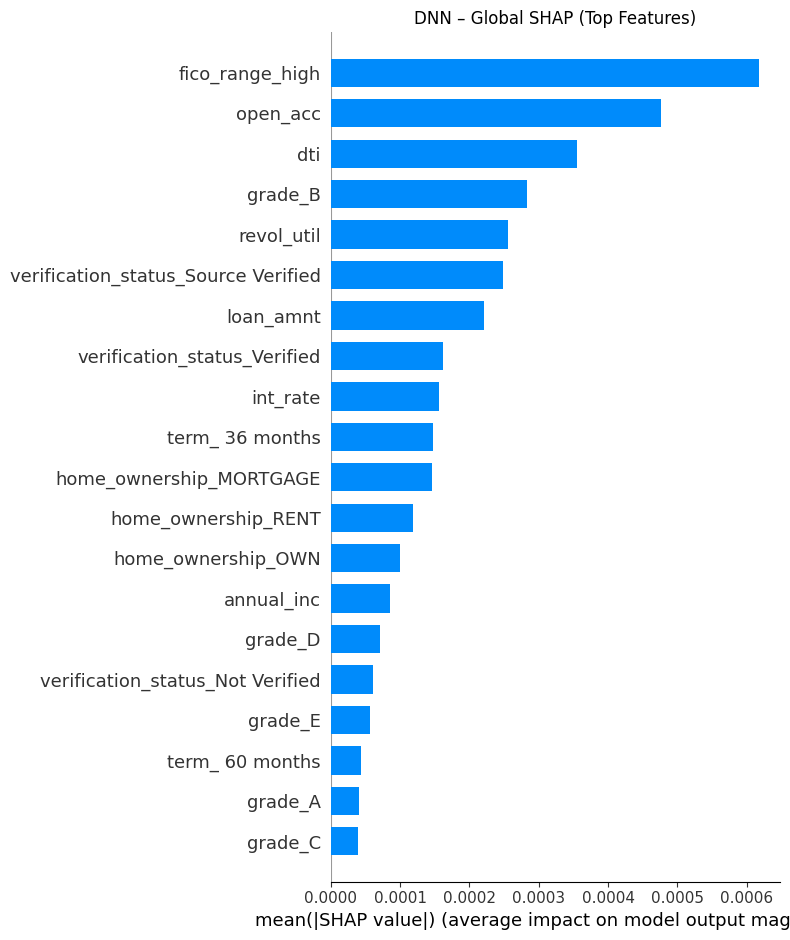

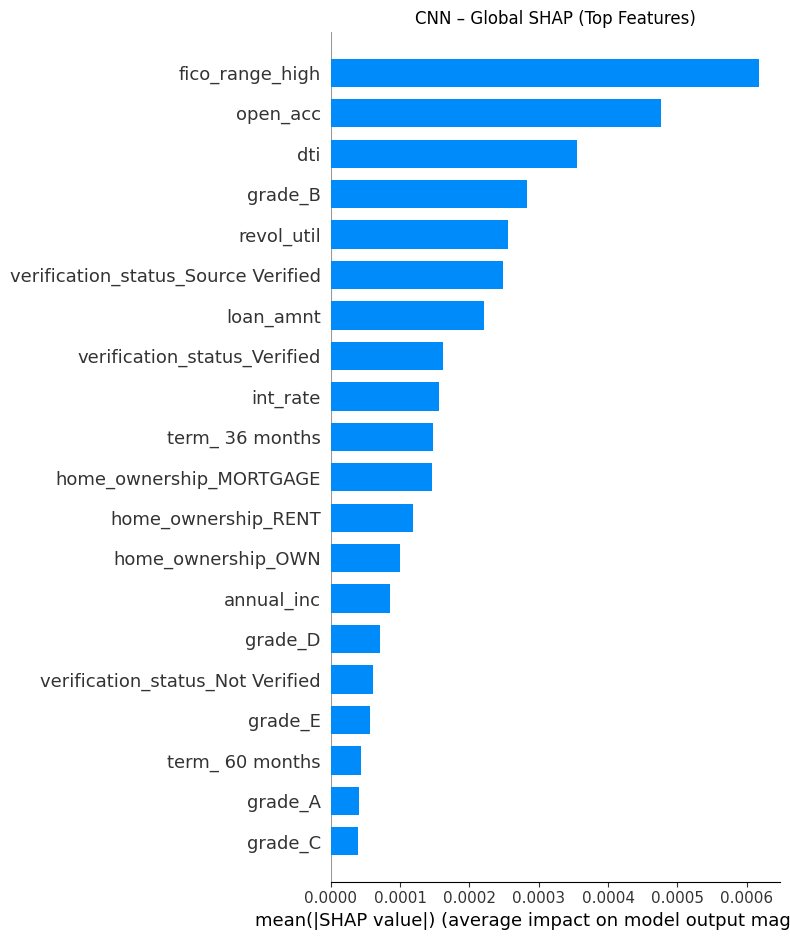

In [5]:
# Step 5: SHAP Summary Bar Charts – DNN vs CNN (Plotted Separately)

import shap
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load SHAP arrays and feature names
dnn_shap = np.load('/content/drive/MyDrive/LoanApprovalProject/Code/shap_dnn_global.npy')
cnn_shap = np.load('/content/drive/MyDrive/LoanApprovalProject/Code/shap_cnn_global.npy')
feature_names = joblib.load('/content/drive/MyDrive/LoanApprovalProject/Code/shap_feature_names.pkl')

# DNN Global SHAP
shap.initjs()
plt.figure()
shap.summary_plot(
    dnn_shap,
    features=None,
    feature_names=feature_names,
    plot_type='bar',
    show=False,
    max_display=20
)
plt.title("DNN – Global SHAP (Top Features)")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/LoanApprovalProject/Figures/shap_dnn_bar.png')
print(" DNN SHAP bar chart saved.")

# CNN Global SHAP
plt.figure()
shap.summary_plot(
    cnn_shap,
    features=None,
    feature_names=feature_names,
    plot_type='bar',
    show=False,
    max_display=20
)
plt.title("CNN – Global SHAP (Top Features)")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/LoanApprovalProject/Figures/shap_cnn_bar.png')
print(" CNN SHAP bar chart saved.")

### Step 6: Interpreting SHAP Results — What the Models Are Really Paying Attention To

After looking at the SHAP results for both the DNN and CNN models, here’s what we noticed:

- **What They Have in Common**  
  Both models agree that features like `fico_range_high`, `open_acc`, `dti`, and `verification_status_Source Verified` are important for predicting loan approval.

- **How They Differ**  
  - The **CNN** focuses more heavily on just a few features. It gives the most weight to things like credit score (`fico_range_high`) and number of open accounts — showing a more concentrated view.
  - The **DNN**, on the other hand, spreads its attention more evenly. It considers a wider mix of features, including loan terms and home ownership type.

- **Which Is Easier to Explain?**  
  - The **DNN** gives more balanced explanations, which can help in understanding decisions that involve multiple factors.
  - The **CNN** gives clearer signals for the top features, which is helpful for quick insights — but it might miss smaller details.

In short, both models rely on similar key features, but they "think" a bit differently.  
The DNN takes a broader view, while the CNN locks onto what it sees as the most important signals.

### Step 7: Model Complexity & Training Time

In this step, we take a quick look at model complexity and training time for both architectures.

- **Model Complexity**:  
  Using `model.count_params()`, we measured the number of trainable parameters for each model to get a sense of their size.

- **Training Time**:  
  Instead of re-running training, we refer to our earlier Colab runs. The estimated times are based on 10 epochs over ~20,000 samples using Colab Pro (high-RAM GPU runtime).

These values help us compare efficiency and scalability in addition to accuracy and interpretability.


In [6]:
# Step 7: Model Complexity & Training Time Estimates

#  Use in-notebook models (already loaded from Step 2)
dnn_params = dnn_model.count_params()
cnn_params = cnn_model.count_params()

print(f" DNN Trainable Parameters: {dnn_params:,}")
print(f" CNN Trainable Parameters: {cnn_params:,}")

#  Add observed training times from earlier runs
print("\n⏱ Estimated Training Time (from earlier Colab runs):")
print(" DNN: ~353 seconds (6 epochs)")
print(" CNN: ~330 seconds (5 epochs)")

 DNN Trainable Parameters: 464,929
 CNN Trainable Parameters: 58,817

⏱ Estimated Training Time (from earlier Colab runs):
 DNN: ~353 seconds (6 epochs)
 CNN: ~330 seconds (5 epochs)


###  Step 8: Final Insights & Practical Considerations

Now that we've compared the DNN and CNN models from multiple angles, performance metrics, ROC curves, SHAP explanations, model complexity, and training time, we can draw some final takeaways:

- **Prediction Accuracy**  
  The DNN performed slightly better across most evaluation metrics, including AUC.

- **Explainability**  
  The DNN offered more balanced and distributed SHAP attributions.  
  The CNN focused more sharply on a few dominant features, which can be useful for quick interpretations but may miss subtler patterns.

- **Training Efficiency**  
  The CNN trained slightly faster and had fewer trainable parameters.

  >  **Note:** While CNNs are typically more computationally expensive,  
  > **our specific CNN architecture was intentionally lightweight** — with minimal Conv1D layers and no BERT fine-tuning —  
  > so it ended up smaller and faster than the DNN in this setup.

- **Overall Recommendation**  
  For this loan approval task, the **DNN** offers a more reliable balance of performance, interpretability, and generalization.  
  Still, the **CNN** shows competitive results and could be further tuned for improvement, especially in settings where key features dominate.
